In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cv2
import gzip
import os
%matplotlib inline

In [4]:
mnist_data_folder = '../data/MNIST_data/'

In [5]:
filename = [
["training_images",os.path.join(mnist_data_folder, "train-images-idx3-ubyte.gz")],
["test_images", os.path.join(mnist_data_folder, "t10k-images-idx3-ubyte.gz")],
["training_labels", os.path.join(mnist_data_folder, "train-labels-idx1-ubyte.gz")],
["test_labels", os.path.join(mnist_data_folder, "t10k-labels-idx1-ubyte.gz")]
]

#### We use an offset of 16 bytes while reading the images because the first byte of first image starts from the 16<sup>th</sup> byte.    
* Byte 0 to 3: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Header
* Byte 4 to 7: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Number of images in file
* Byte 8 to 11: &nbsp;&nbsp;&nbsp; Number of rows in each image
* Byte 12 to 15: &nbsp;&nbsp; Number of columns in each image

#### Similarly we use an offset of 8 bytes while reading labels because the first byte of first label starts from 8<sup>th</sup> byte.

In [42]:
mnist = {}
for name in filename[:2]:
    with gzip.open(name[1], 'rb') as f:
        mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28, 1)
        
for name in filename[-2:]:
    with gzip.open(name[1], 'rb') as f:
        mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=8).reshape(-1, 1)
        

In [43]:
print(mnist.keys())
print(mnist['training_images'].shape)
print(mnist['training_labels'].shape)
print(mnist['test_images'].shape)
print(mnist['test_labels'].shape)

dict_keys(['training_images', 'training_labels', 'test_images', 'test_labels'])
(60000, 28, 28, 1)
(60000, 1)
(10000, 28, 28, 1)
(10000, 1)


[5]
(28, 28, 1)
(28, 28)


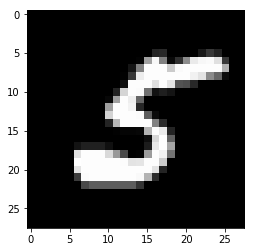

In [46]:
import random
index = random.randint(0, len(mnist['training_images']))
image = mnist['training_images'][index]
label = mnist['training_labels'][index]
print(label)
print(image.shape)
image = image.squeeze()
print(image.shape)
plt.imshow(image, cmap='gray')
plt.show()

In [52]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(mnist['training_images'], mnist['training_labels'], test_size=0.20, random_state=42)
X_test = mnist['test_images']
y_test = mnist['test_labels']


In [53]:
assert(len(X_train) == len(y_train))
assert(len(X_validation) == len(y_validation))
assert(len(X_test) == len(y_test))
print()
print("Image Shape: {}".format(X_train.shape))
print("Label Shape: {}".format(y_train.shape))
print()
print("Training Set:   {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_validation)))
print("Test Set:       {} samples".format(len(X_test)))


Image Shape: (48000, 28, 28, 1)
Label Shape: (48000, 1)

Training Set:   48000 samples
Validation Set: 12000 samples
Test Set:       10000 samples


The LeNet architecture only accepts 32x32xC images, where C is the number of color channels.

In order to reformat the MNIST data into a shape that LeNet will accept, we pad the data with two rows of zeros on the top and bottom, and two columns of zeros on the left and right (28+2+2 = 32).

In [54]:
# Pad images with 0s
# np.pad(np_array, ((axis_0 first item, axis_0 second item),(top, bottom),(left, right),(axis_3 first item, axis_3 last item)))
X_train      = np.pad(X_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_validation = np.pad(X_validation, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_test       = np.pad(X_test, ((0,0),(2,2),(2,2),(0,0)), 'constant')
    
print("Updated Image Shape: {}".format(X_train[0].shape))

Updated Image Shape: (32, 32, 1)
